# テキストの分類 

多数のテキストがあったとします。これらを、何かの基準によって分類整理したいとします。たとえば、ジャンルごとにグループ分けすることを想定してみてください。こうしたグループをクラスターともいいます。また、グループ分けすることをクラスタリングといいます。

## 内容による分類

この章では、多数のテキスト（文書集合）を対象に、内容（テーマ）によって分類する方法について学びます。取り上げる手法は、クラスター分析とトピックモデルです。 取り上げるデータは日本の歴代総理大臣の所信表明演説です。演説は首相官邸サイト[^kantei]  からもダウンロードできますが、GitHubにレポジトリ化されているユーザーがいますので、それを利用させてもらいます。

[^kantei]: <https://www.kantei.go.jp/>

 + GitHub(<https://github.com/yuukimiyo/GeneralPolicySpeechOfPrimeMinisterOfJapan.) にアクセスする
 + 右端にある [Clone or download] をクリック
 + ポップアップの下にある [Download Zip] を選択
 + longfilename フォルダにある utf8 (Mac/Linux) を適当なフォルダに移す(以下ではdataフォルダにコピーした場合を想定します)
  

ここではカレントフォルダに data/utf8 というフォルダがあり、ここにすべての所信表明演説ファイルがあるとして、分析を進めていきます。


In [2]:
import os
## https://github.com/yuukimiyo/GeneralPolicySpeechOfPrimeMinisterOfJapan
## からダウンロードしたファイルを解凍し、longfilenameフォルダにある
## utf8フォルダを data 直下に配置
files = ['data/utf8/' + path for path in os.listdir('data/utf8')]
print(len(files))
print(files[:3])

82
['data/utf8/19641121_47_sato-eisaku_general-policy-speech.txt', 'data/utf8/20131015_185_abe-shinzo_general-policy-speech.txt', 'data/utf8/19570227_26_kishi-nobusuke_general-policy-speech.txt']




ファイル名が長いので、グラフなどで表示するには不便です。そこで、国会の会期番号と首相名だけにまとめた文字列のリストを用意しておきましょう。


In [5]:
import re
pattern = 'data/utf8/\d{8}_(\d{1,3}_[a-z]{1,}-[a-z]{1,})_general-policy-speech.txt'
results = [re.match(pattern, file_name) for file_name in files]
prime_names = [ res.group(1) for res in results]
print(prime_names[:3])

['47_sato-eisaku', '185_abe-shinzo', '26_kishi-nobusuke']



これまでにも何度か利用したストップワードを用意しておきます。

In [7]:
# import urllib.request
# url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
# urllib.request.urlretrieve(url, 'stopwords.txt')
stopwords = []
with open('data/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [w.strip() for w in f]
## ストップワードをさらに追加
stopwords.extend(['あの', 'この', 'ある', 'する', 'いる', 'できる', 'なる', 'れる', 'の', 'は'])
## セットに変更（形態素が重複して登録されているのを避けるため）
stopwords = set(stopwords)
print(f'ストップワードの総数 = {len(stopwords)}')

ストップワードの総数 = 321


## クラスター分析

最初に、データ集合（ここでは所信表明演説）をグループ分けする古典的な手法を紹介しましょう。クラスター分析と言われる手法で、以下に示すような**デンドログラム**を使って解釈されることで知られています。


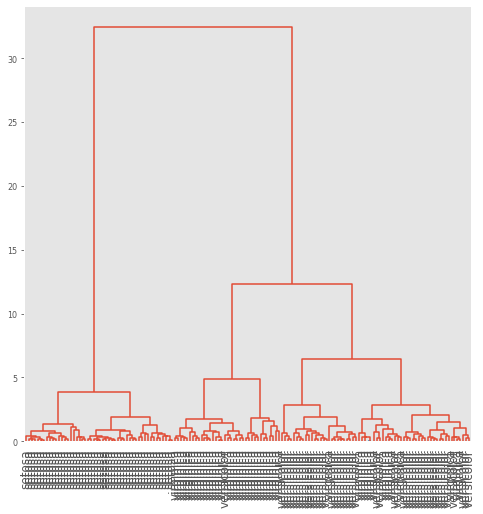

In [8]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.cluster.hierarchy import linkage, dendrogram
iris = sns.load_dataset('iris')
result = linkage(iris.iloc[:, :4], 
                  # metric='braycurtis', 
                  # metric='canberra', 
                  # metric='chebyshev', 
                  # metric='cityblock', 
                  # metric='correlation', 
                  # metric='cosine', 
                  metric='euclidean', 
                  # metric='hamming', 
                  # metric='jaccard', 
                  # method='single',
                  # method='average',
                  # method='complete',
                  # method='weighted',
                  method='ward')
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
dendrogram(result, orientation='top', labels=list(iris.species),
           color_threshold=0.01, ax=ax)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.grid()


In [5]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica




## 階層的クラスター分析

データをグループに分ける技法はさまざまですが、前節で紹介したのは**階層的クラスター分析**です。
クラスター分析では、大きく2つの処理が行われています。まず、個体間、あるいはクラスター間（あるいは個体とクラスター間）の距離を測ります。
距離を測ると言っても、さまざまな方法があります。よく知られているのがユークリッド距離です。


たとえば、ある点 a が座標軸の $x_1=2, y_1=2$ にあり、もう1つの点 b が  $x_2=6, y_2=5$ にあったとします。




(1.0, 6.0)

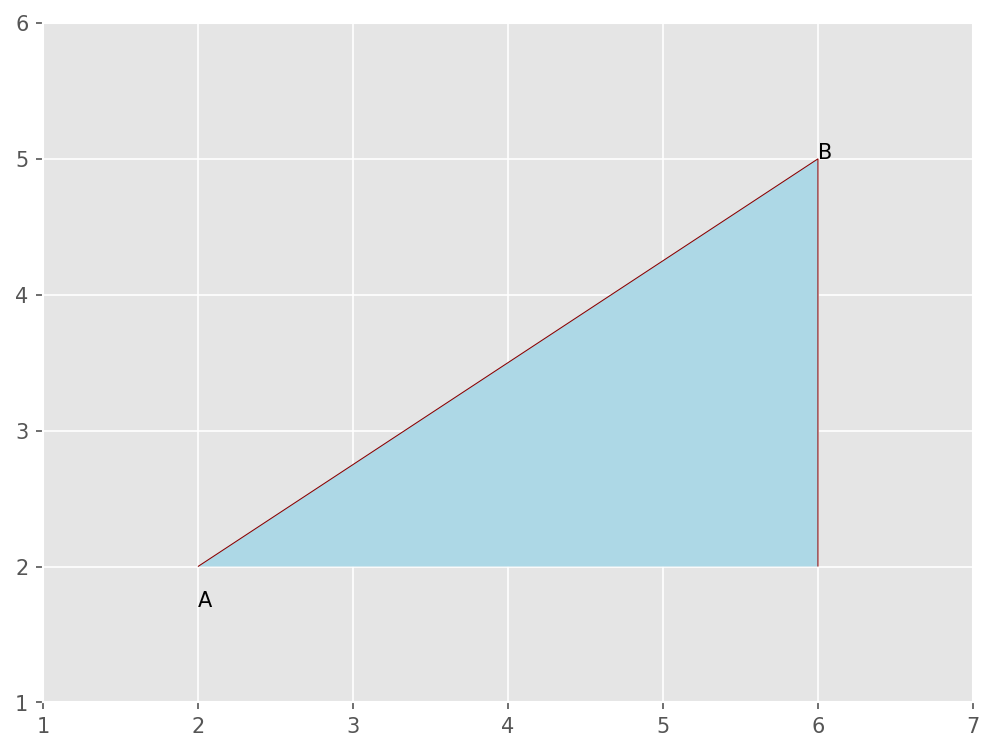

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
plt.style.use('ggplot')
## ちなみに画像サイズを変えるには次のようにする
plt.figure(figsize=(8, 6), dpi=150)
pts = np.array([(2,2), (6,5), (6,2)])
p = Polygon(pts, closed=False, fc='lightblue', ec='darkred')
ax = plt.gca()
ax.add_patch(p)
ax.text(2,1.7, 'A')
ax.text(6,5, 'B')
ax.set_xlim(1,7)
ax.set_ylim(1,6)
# plt.savefig('AB.png')

すると A と B のユークリッド距離は、ピタゴラスの定理により、以下のように求められます。

    $$d\left(A, B\right)   = \sqrt { (x_0 - x_1)^2 + (x_1 - x_2)^2 }$$

先に利用した scipy ライブラリの `linkage()` では、2つの個体間の距離の求め方として、ユークリッド距離の他、マンハッタン距離やミンコフスキー距離など、さまざまな計算方法を引数 `metric` で指定できます。

次に求められた距離に基づいて個体、あるいはクラスターを結合します。この結合の仕方には複数の方法があります。たとえば A というクラスターと B というクラスターがあったとします。この2つのクラスター間の距離は、A と B それぞれの個体のペアを取り出して距離を測り、その最大値をクラスター間の距離とする方法や、最小値あるいは平均値を距離として使う方法などがあります。この方法は、`linkage()` の `method` 引数で指定します。


## 非階層的クラスター分析

階層的クラスター分析では、個体のペアの距離を計算することになります。そのため、個体数（データ数）が大きくなると、計算負荷が非常に大きくなります。そこで、すべてのペア間の距離を求める代わりに、あらかじめ中心点をいくつか決め、その点と個体との距離を求めることを繰り返す方法があります。




In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.cluster import KMeans
iris = sns.load_dataset('iris')
model = KMeans(n_clusters=3, random_state=0)
model.fit(iris.iloc[:, :4])
model.labels_


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2], dtype=int32)

`model.labels_` に k-means 法による分類結果が入っています。




### エルボー法

**エルボー法** は、クラスター内平方和(WCSS,Within-cluster sum of squares) を最小にする k を推定します。


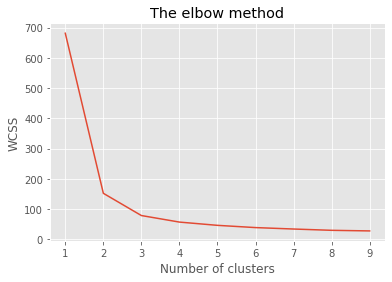

In [7]:
wcss = []

for i in range(1, 10):
    k_means = KMeans(n_clusters = i, init = 'k-means++',
                     max_iter = 300, n_init = 30, random_state = 0)
    k_means.fit(iris.iloc[:, :4])
    wcss.append(k_means.inertia_)

plt.plot(range(1, 10), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()


### シルエット・プロット

**シルエット・プロット** では以下のようなグラフを使って、設定した k の妥当性を判断します。



In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score
print('全データのシルエットスコア平均値')
silhouette_avg = silhouette_score(iris.iloc[:, :4], model.labels_)
print(silhouette_avg)
print('-----')
print('最初の10個体のシルエットスコア')
sample_silhouette_values = silhouette_samples(iris.iloc[:, :4], model.labels_)
print(sample_silhouette_values[:10])
print('-----')
print('0 と分類された最初の10個体のシルエットスコア')
print(sample_silhouette_values[model.labels_==0][:10])

全データのシルエットスコア平均値
0.5528190123564102
-----
最初の10個体のシルエットスコア
[0.85295506 0.81549476 0.8293151  0.80501395 0.8493016  0.74828037
 0.82165093 0.85390505 0.75215011 0.825294  ]
-----
0 と分類された最初の10個体のシルエットスコア
[0.05340075 0.11798213 0.49927538 0.61193633 0.36075942 0.5577792
 0.54384277 0.55917348 0.44076207 0.56152256]


Text(0.5, 0, 'silhouette coefficient')

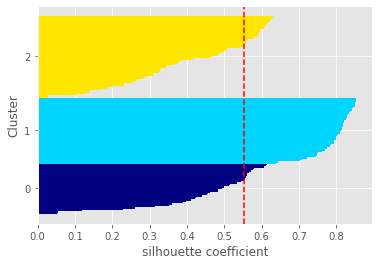

In [15]:
## matplotlib のカラーテーマを指定
import matplotlib.cm as cm
import numpy as np
k = 3
## 個体ごとにバーを描くための設定
y_axis_lower, y_axis_upper = 0,0
y_ticks = []
## 個体のクラスター番号 [0,1,2]
labels = np.unique(model.labels_)

for i in range(k):
    ## 各個体のシルエット値を抽出
    values = sample_silhouette_values [model.labels_==i]
    values.sort()
    ## y 軸の範囲
    y_axis_upper += len(values)
    colr = cm.jet(float(i)/k)
    ## バープロットの描画
    plt.barh(range(y_axis_lower, y_axis_upper),
             values, 
             height=1.0, 
             color=colr) 
    y_ticks.append((y_axis_lower+y_axis_upper)/2)
    ## 次のクラスターの y 軸を設定
    y_axis_lower += len(values)
## シルエット係数の平均値
plt.axvline(silhouette_avg, color='red', linestyle='--')
## クラスター番号
plt.yticks(y_ticks, labels)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')



[^silhouette]: <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py%5D>



#### iris データ

ちなみに、scikit-learn にも iris データが付属していますが seaborn とは異なり、辞書の形式で保存されています。そのため処理手順が異なってきます。
参考のため、scikit-learn の iris データを使ってクラスター分析を実行してみましょう。

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.datasets import load_iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [8]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(iris.data)
## クラスタリング結果ラベルの取得
model.labels_



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

## 所信表明演説ファイル
さて、前置きが長くなりましたが、首相所信表明演説から単語文書行列を作成し、これをデータとして演説をクラスターに分けてみましょう。


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import my_mecab_stopwords as my_tokenizer

args={'stopwords_list': stopwords}
vectorizer = CountVectorizer(input='filename',
                             token_pattern='(?u)\\b\\w+\\b',
                             lowercase=False, max_df=0.5,
                             max_features=50,
                             tokenizer=lambda text: my_tokenizer.tokens(text, **args))
prime_dtm = vectorizer.fit_transform(files)

In [10]:
prime_dtm

<82x50 sparse matrix of type '<class 'numpy.int64'>'
	with 1782 stored elements in Compressed Sparse Row format>

In [11]:
prime_dtm.toarray().shape

(82, 50)

さて、単語文章行列が作成されたので、階層的クラスター分析を適用してみましょう。`linkage` メソッドに適用する際には配列に変換します。

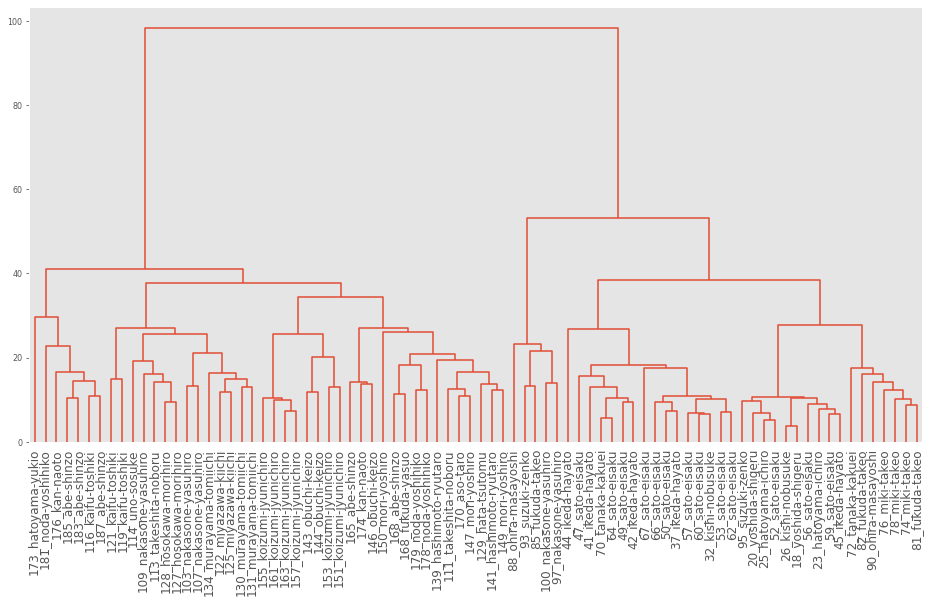

In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.cluster.hierarchy import linkage, dendrogram
iris = sns.load_dataset('iris')
result = linkage(prime_dtm.toarray(), 
                  # metric='braycurtis', 
                  # metric='canberra', 
                  # metric='chebyshev', 
                  # metric='cityblock', 
                  # metric='correlation', 
                  # metric='cosine', 
                  metric='euclidean', 
                  # metric='hamming', 
                  # metric='jaccard', 
                  # method='single',
                  # method='average',
                  # method='complete',
                  # method='weighted',
                  method='ward'
                 )
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
dendrogram(result, orientation='top',
           labels=prime_names, color_threshold=0.01, ax=ax)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.grid()


## 森鴎外と夏目漱石

Python速習で取り上げた２人の作家の識別をクラスター分析で試してみましょう。




In [13]:
import os
files = os.listdir('data/writers')
files = sorted(files)
path = os.path.abspath('data/writers')
files_path = [path + '/' + txt_name for txt_name in files]

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(input='filename', ngram_range=(2,2), analyzer='char')
docs = cv.fit_transform(files_path)
bigrams = [(v, k)  for k, v in (cv.vocabulary_).items()  if k in ['が、', 'て、', 'と、', 'に、', 'は、', 'も、','ら、','で、']]

bigrams_idx = [ i[0]  for i in sorted(bigrams)]
docs.toarray()[:, bigrams_idx]

array([[ 66, 167,  67,  47,  55,  73,  10,  44],
       [ 66, 194,  52,  34,  81,  67,  25,  34],
       [ 48, 135,  76,  29,  36,  35,  14,  37],
       [ 63, 112,  53,  36,  47,  69,  21,  35],
       [ 31, 143,  37,  86,  41,  40,  22,  51],
       [ 28,  70,  36,  24,  41,  39,  10,  33],
       [ 38, 102,  46,  29,  32,  42,  18,  28],
       [ 33, 138,  38,  41,  39,  22,  13,  44]])

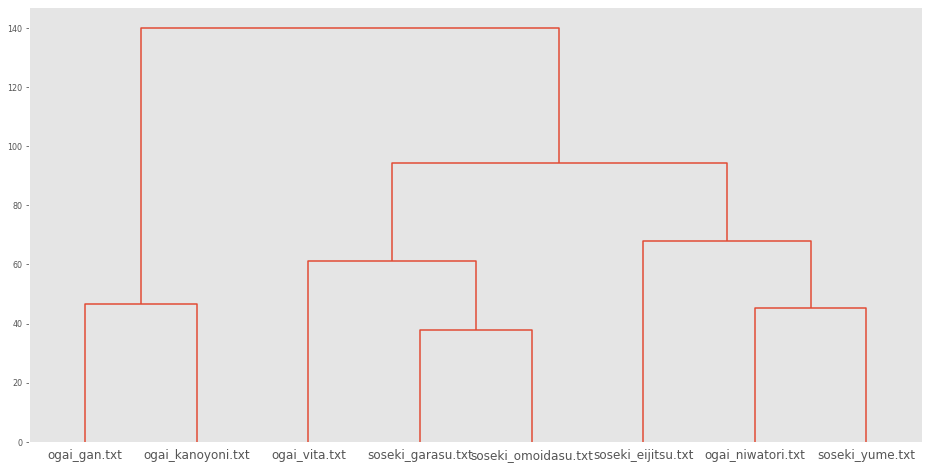

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.cluster.hierarchy import linkage, dendrogram
result = linkage(docs.toarray()[:, bigrams_idx], 
                  # metric='braycurtis', 
                  # metric='canberra', 
                  # metric='chebyshev', 
                  # metric='cityblock', 
                  # metric='correlation', 
                  # metric='cosine', 
                  metric='euclidean', 
                  # metric='hamming', 
                  # metric='jaccard', 
                  # method= single',
                  # method= 'average',
                  # method='complete',
                  # method='weighted',
                 method='ward'
                 )
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
dendrogram(result, orientation='top', labels=files, color_threshold=0.01, ax=ax)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.grid()


In [10]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=0)
model.fit(docs.toarray()[:, bigrams_idx])
## ラベル（漱石が1で鴎外が0）が分離できているかを確認
model.labels_

array([0, 0, 1, 1, 1, 1, 1, 1], dtype=int32)